## Environment setup and data pre-processing

In [6]:
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

#from config import *

#df = pd.read_csv("/content/XAUUSDM15.csv", names=['timestamp','open','high','low','close','volume'])
column= ['time','open','high','low','close','volume']
df = pd.read_csv('https://github.com/vietnc/ML/raw/main/XAUUSD15.csv', sep='\t', names=column)
#print(df.count())

# Rename bid OHLC columns
#df.rename(columns={'Time': 'timestamp', 'Open': 'open', 'Close': 'close',
#                   'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
date_time = pd.to_datetime(df.pop('time'),format='%Y-%m-%d %H:%M')
#df.set_index('time', inplace=True)
#df = df.astype(float)

# Add additional features
df['momentum'] = df['volume'] * (df['close'] - df['open'])
df['Wy'] = df['high'] - df['low']
df['Wx'] = df['close'] - df['open']
df['MA34'] = df['close'].rolling(3).mean().fillna(0)
df['MA89'] = df['close'].rolling(89).mean().fillna(0)
df['pos'] = df['close'] - df['MA34'] + 3*(df['MA34'] -df['MA89'])
#previous movement
df['pre'] = df['close'].shift(1).fillna(0) - df['open'].shift(1).fillna(0)


(-71.89699999999993, 54.63000000000011, 0.11999999999989086, 83.15999999999985)

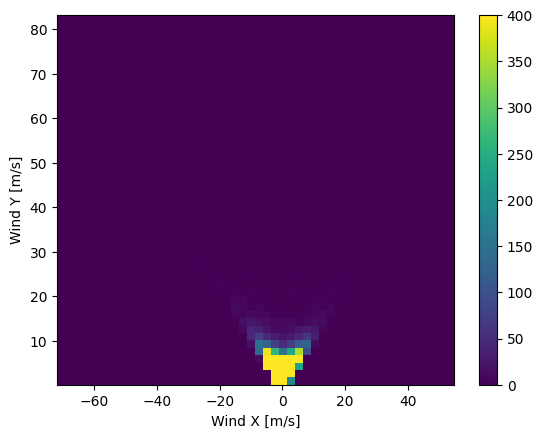

In [7]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [8]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

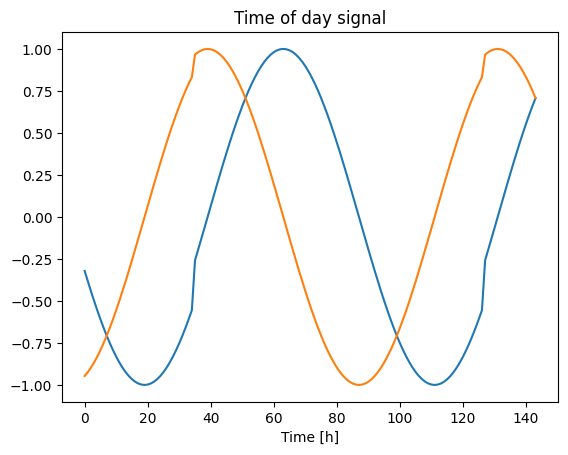

In [9]:
plt.plot(np.array(df['Day sin'])[:144])
plt.plot(np.array(df['Day cos'])[:144])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

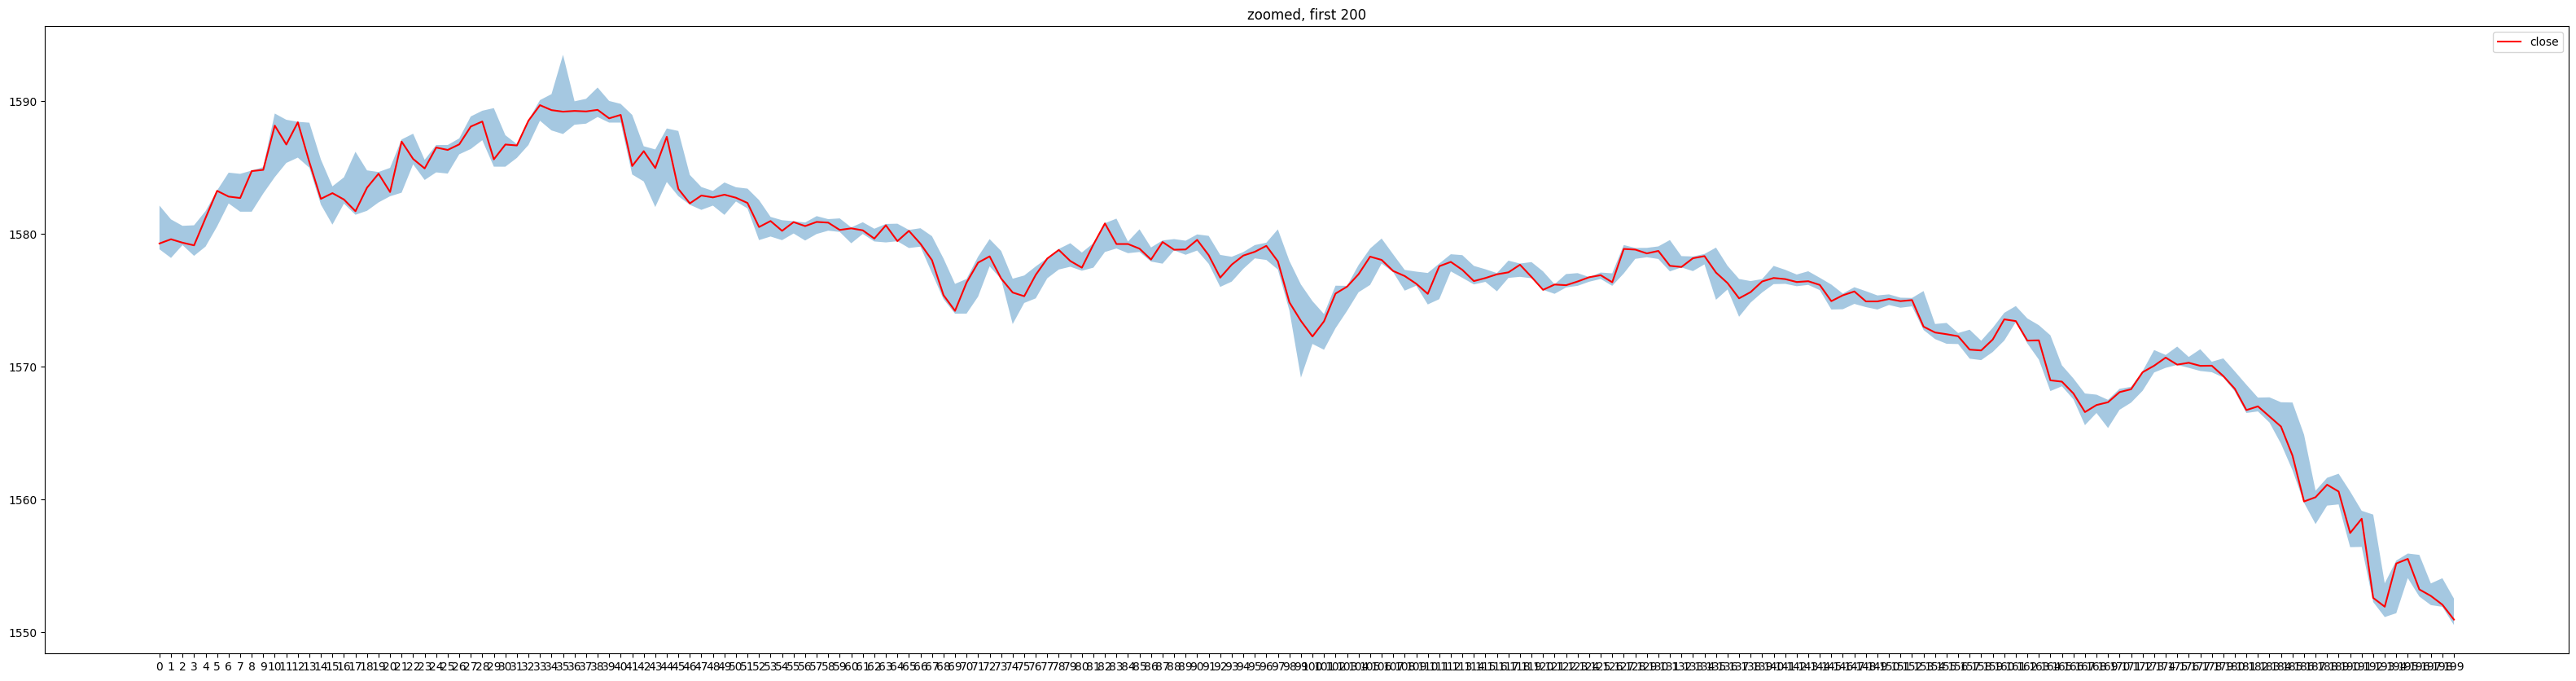

In [10]:

p = df[:200].copy()
ax = p.plot( y='close', c='red', figsize=(40,10))
index = [str(item) for item in p.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('zoomed, first 200')
plt.show()

Setup training dataset

In [148]:

def create_dataset(dataset, look_back=96):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)


# Scale and create datasets
target_index = df.columns.tolist().index('close')
high_index = df.columns.tolist().index('high')
low_index = df.columns.tolist().index('low')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler().fit(df.iloc[:, 3:4].astype('float32')) # Close index) # Close index
dataset = scaler.fit_transform(dataset)

# Create y_scaler to inverse it later
y_scaler = MinMaxScaler().fit(df.iloc[:, 3:4].astype('float32'))
#t_y = df['close'].values.astype('float32')
#t_y = np.reshape(t_y, (-1, 1))
#y_scaler = y_scaler.fit(t_y)

X, y = create_dataset(dataset, look_back=96)
y = y[:, target_index]

train_size = int(len(X) * 0.9)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

In [151]:
print(dataset)


[[0.13087368 0.12397015 0.13242412 ... 0.02653494 0.74992704 0.9330548 ]
 [0.1290747  0.12289739 0.13174999 ... 0.03806025 0.75000465 0.93301   ]
 [0.12942421 0.12239909 0.13275278 ... 0.05156362 0.75008225 0.9329652 ]
 ...
 [0.88444316 0.87914515 0.89301336 ... 0.7211443  0.9587724  0.30118376]
 [0.88286006 0.8793721  0.89298236 ... 0.6913417  0.9587368  0.30110157]
 [0.8847033  0.8807335  0.89480746 ... 0.66071975 0.95870113 0.30101937]]


## Model creation

In [152]:
model = Sequential()
model.add(
   LSTM(34, input_shape=(X.shape[1], X.shape[2]),
                       return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 96, 34)            6936      
                                                                 
 lstm_31 (LSTM)              (None, 96, 10)            1800      
                                                                 
 dropout_12 (Dropout)        (None, 96, 10)            0         
                                                                 
 lstm_32 (LSTM)              (None, 4)                 240       
                                                                 
 dense_20 (Dense)            (None, 4)                 20        
                                                                 
 dense_21 (Dense)            (None, 1)                 5         
                                                                 
Total params: 9001 (35.16 KB)
Trainable params: 9001 

In [154]:
# Save the best weight during training.
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("/content/ckpoint2.hd5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Fit
callbacks_list = [checkpoint] #callbacks=callbacks_list,
history = model.fit(trainX, trainY, epochs=2, batch_size=1000, verbose=0, callbacks=callbacks_list, validation_split=0.1)



Epoch 1: val_loss improved from inf to 0.02295, saving model to /content/ckpoint2.hd5

Epoch 2: val_loss improved from 0.02295 to 0.00915, saving model to /content/ckpoint2.hd5


## Benchmark

In [159]:
model.load_weights("/content/ckpoint2.hd5")
pred = model.predict(testX)


313/313 [==============================] - 9s 29ms/step


In [160]:
pred = y_scaler.inverse_transform(pred)
close = y_scaler.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))
predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['close'] = pd.Series(np.reshape(close, (close.shape[0])))

p = df[-pred.shape[0]:].copy()
predictions.index = p.index
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low', 'high']], right_index=True, left_index=True)
predictions.head()


,predicted,close,low,high
90009,1849.043579,1986.375000,1983.828,1986.525
90010,1849.223389,1985.017944,1984.825,1990.275
90011,1849.389404,1989.835083,1987.935,1990.135
90012,1849.559204,1988.454956,1988.274,1990.235
90013,1849.705322,1989.897949,1988.895,1990.565


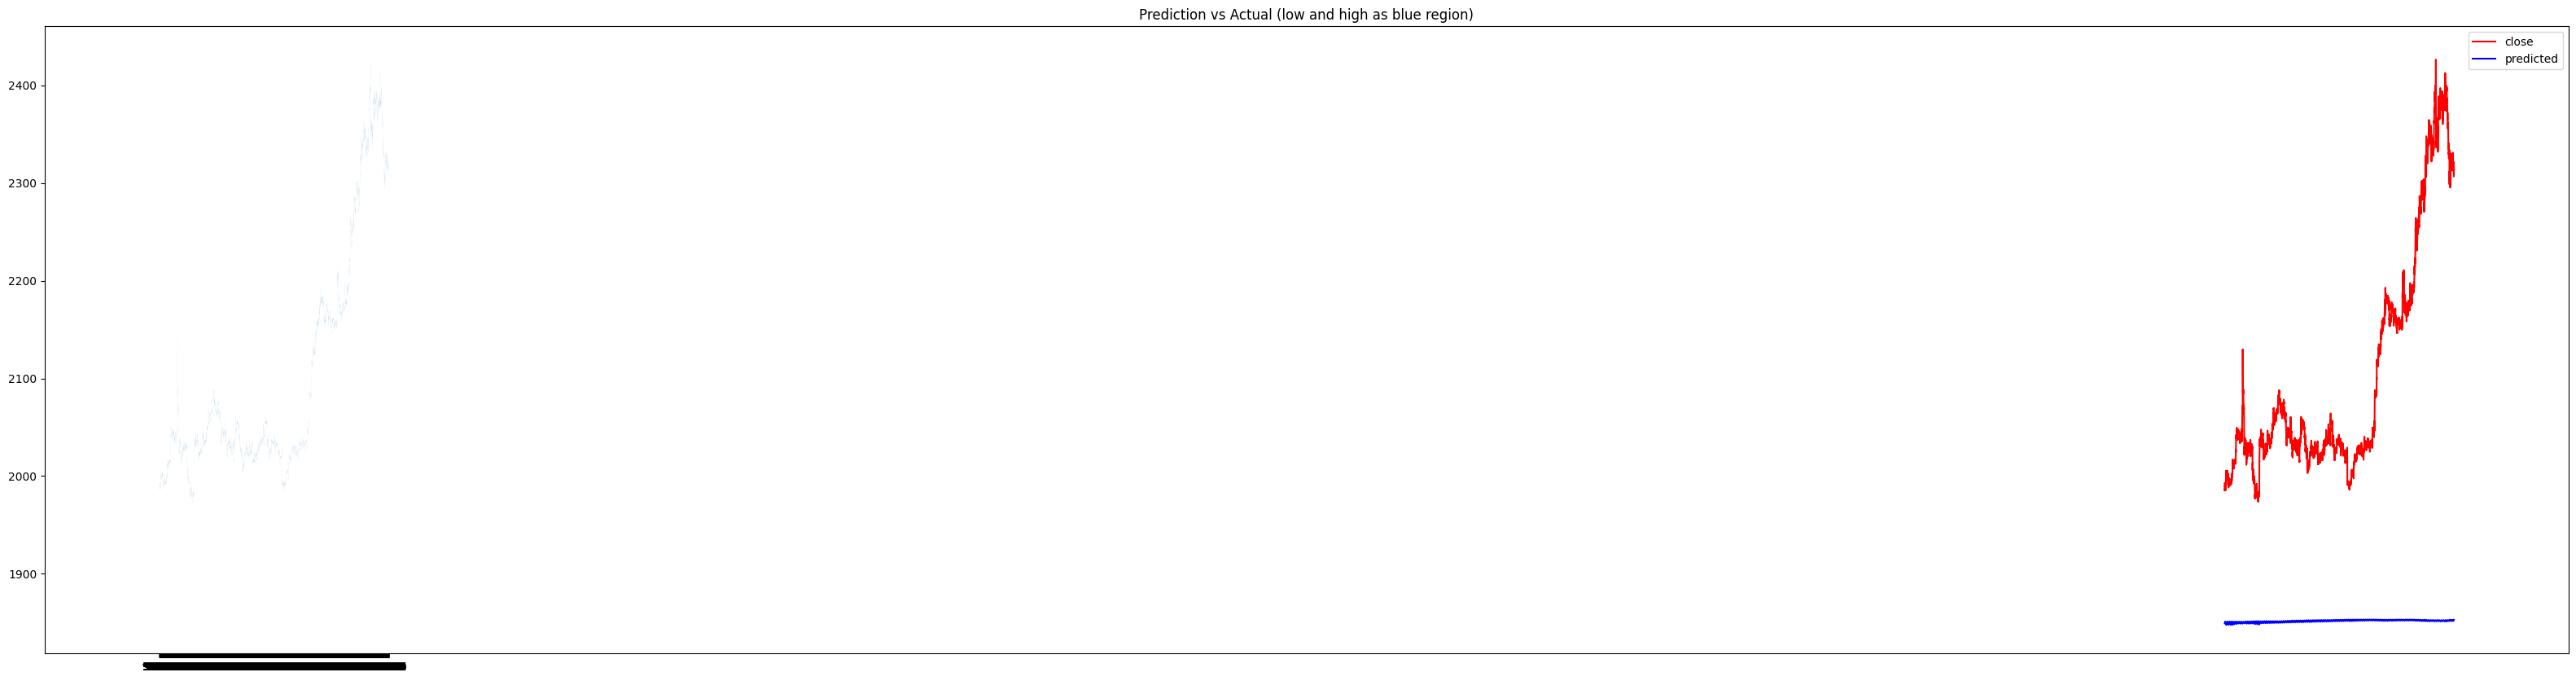

<Figure size 1000x1000 with 0 Axes>

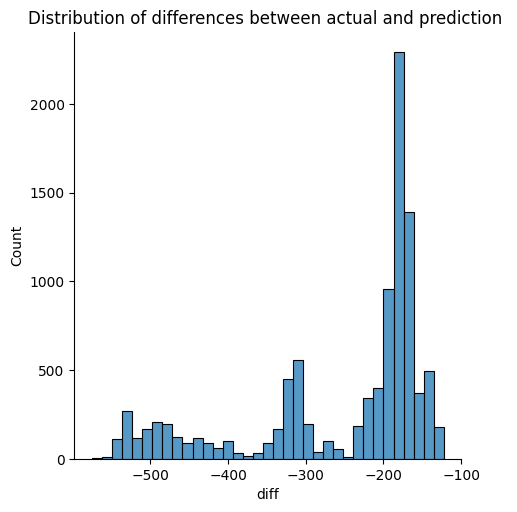

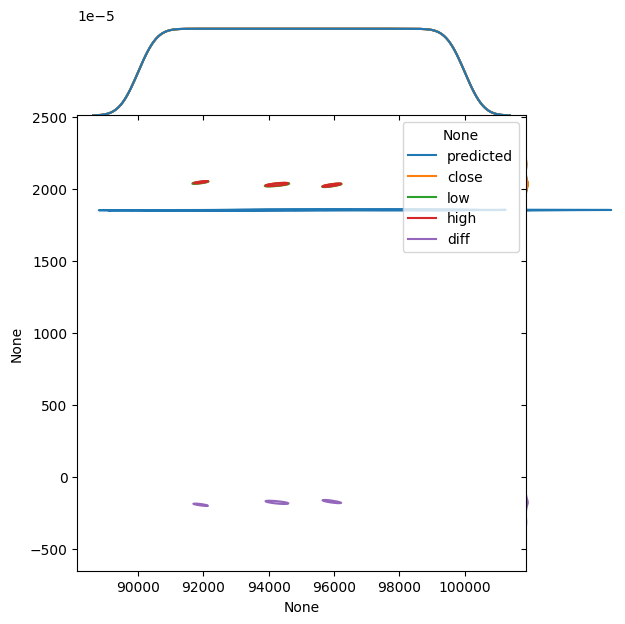

MSE :  77601.17275264153
MAE :  252.68925703787707


count    9991.000000
mean     -252.689257
std       117.263329
min      -575.222900
25%      -314.513184
50%      -190.227905
75%      -174.339294
max      -122.211182
Name: diff, dtype: float64

In [161]:
ax = predictions.plot( y='close', c='red', figsize=(40, 10))
ax = predictions.plot( y='predicted', c='blue', figsize=(40, 10), ax=ax)
index = [str(item) for item in predictions.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('Prediction vs Actual (low and high as blue region)')
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['close']
plt.figure(figsize=(10, 10))
sns.displot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction ')
plt.show()

g = sns.jointplot(data=predictions, kind="kde", space=0)
plt.title('Distributtion of error and price')
plt.show()

# predictions['correct'] = (predictions['predicted'] <= predictions['high']) & (predictions['predicted'] >= predictions['low'])
# sns.factorplot(data=predictions, x='correct', kind='count')

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close'].values))
predictions['diff'].describe()